## Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

from cdd import CDD


In [2]:
# data import
df_s = pd.read_csv('df_s_convex_concave.csv')
df_s_true = pd.read_csv('df_s_true_convex_concave.csv')
df_t = pd.read_csv('df_t_convex_concave.csv')
df_t_true = pd.read_csv('df_t_true_convex_concave.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_convex_concave.csv')

In [3]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)

## DAR

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 256)
        self.relu = nn.ReLU()
        self.h2 = nn.Linear(256, 256)
        self.h3 = nn.Linear(256, 256)
        self.h4 = nn.Linear(256,10)
        self.reg = nn.Linear(10, 1)
        self.drop1 = nn.Dropout()
        self.drop2 = nn.Dropout()
        
        
        
    def forward(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h3(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.drop1(h1_x)
        h1_x = self.h4(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.drop2(h1_x)
        h1_x = self.reg(h1_x)

        return h1_x
    
    def output(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h3(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h4(h1_x)
        f_x = self.relu(h1_x)
        y_hat = self.reg(h1_x)
        return {'f_x':f_x, 'output':y_hat}

### Pretrained

In [21]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_loss = 1000
for epoch in range(10000):
    optimizer.zero_grad()

    model_output_s = model.output(x_s)
    latent_x_s = model_output_s['f_x']
    y_s_hat = model_output_s['output']



    # mse loss
    y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s)
    y_s_mse.backward()
    if epoch % 100 == 0:
        print(f"Epoch : {epoch}, total_loss = {y_s_mse}")
    optimizer.step()
    val_loss = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
    if best_loss > val_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model)
        print(f"Saving... val mse{val_loss}")

torch.save(best_model, "./best_pretrained_model.pt")

Epoch : 0, total_loss = 0.7143955826759338
Saving... val mse0.7054800987243652
Saving... val mse0.454529345035553
Saving... val mse0.4439375400543213
Saving... val mse0.43989863991737366
Saving... val mse0.4392271637916565
Saving... val mse0.4201011657714844
Saving... val mse0.4126852750778198
Saving... val mse0.4075963795185089
Saving... val mse0.4056539535522461
Saving... val mse0.39722326397895813
Saving... val mse0.39240118861198425
Saving... val mse0.3914598822593689
Saving... val mse0.3878146708011627
Saving... val mse0.38114258646965027
Saving... val mse0.3781171441078186
Saving... val mse0.37663203477859497
Saving... val mse0.37343278527259827
Saving... val mse0.36967897415161133
Saving... val mse0.36814892292022705
Saving... val mse0.36705484986305237
Saving... val mse0.36468008160591125
Saving... val mse0.3630286753177643
Saving... val mse0.36253949999809265
Saving... val mse0.3611425459384918
Saving... val mse0.3592180609703064
Saving... val mse0.35853567719459534
Saving... 

KeyboardInterrupt: 

### DA

In [26]:
model = torch.load("./best_pretrained_model.pt")
model_output_s = model.output(x_s)
latent_x_s = model_output_s['f_x']
y_s_hat = model_output_s['output']

model_output_t_labeled = model.output(x_t_labeled)
latent_x_t_labeled = model_output_t_labeled['f_x']
y_t_labeled_hat = model_output_t_labeled['output']

model_output_t = model.output(x_t)
latent_x_t = model_output_t['f_x']
y_t_hat = model_output_t['output']

# mse loss
y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
y_t_mse = torch.nn.functional.mse_loss(y_t_labeled_hat, y_t_labeled)
y_t_real_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_real_mse}")

source mse : 0.0006118146702647209, labeled target mse : 1.9264698028564453, target mse : 1.9639837741851807


In [9]:
class MELU(torch.nn.Module): # alpha(max(0,x) + min(1,exp(x)))
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(MELU, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.zeros(self.weights.shape)
        monotonic_weights[self.weights >= 0] = self.weights[self.weights >= 0]
        monotonic_weights[self.weights < 0] = torch.exp(self.weights[self.weights < 0])
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'


In [16]:
class MELU_ELU_NN(nn.Module):
    def __init__(self):
        super(MELU_ELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 16
        hidden_sizes = [self._num_units] + [16,16]
        layers = []
        layers.append(MELU(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(MELU(in_features, out_features))
        layers.append(MELU(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
        
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ELU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ELU()(-outputs_list[1])],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

    def output(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ELU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ELU()(-outputs_list[1])],axis=1)
            outputs = result_list
        output1 = outputs
        outputs = self.model[-1](outputs)
        return {'f_x':output1, 'output':outputs}

In [20]:
mapper = MELU_ELU_NN()
optimizer = optim.Adam(mapper.parameters(), lr=0.01)
best_mapper = copy.deepcopy(mapper)
best_loss = 1000
loss_list = []
bn = len(x_t_labeled)
for epoch in range(20000):
    optimizer.zero_grad()

    latent_x_s = x_s
    
    mapper_output_t_labeled = mapper.output(x_t_labeled)
    latent_x_t_labeled = mapper_output_t_labeled['output']
    
    
    # source latent에서 batch 추출
    batch_latent_x_s_index = torch.randperm(latent_x_s.size(0))[:bn]
    batch_latent_x_s = latent_x_s[batch_latent_x_s_index]


    # cdd loss
    feats_toalign_S = [batch_latent_x_s, torch.tensor([1]).repeat(len(batch_latent_x_s),1)]
    feats_toalign_T = [latent_x_t_labeled, torch.tensor([1]).repeat(len(latent_x_t_labeled),1)]
    cdd = CDD(kernel_num=(10,10), kernel_mul=(2,2), num_layers=2, num_classes=1, intra_only=True)
    cdd_loss = cdd.forward(feats_toalign_S, feats_toalign_T, [bn], [bn])['cdd']

    # ns loss
    epsilon_k = 5

    f_s_vector = latent_x_s
    f_t_vector = latent_x_t_labeled

    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors=epsilon_k)
    knn.fit(y_s, np.array(range(len(y_s))))
    total_ns_loss = 0
    for i in range(bn):
        best_dist = 1000
        error = 0
        neighbors = knn.kneighbors(y_t_labeled[i].reshape(-1,1))[1][0].tolist()
        for index_i in neighbors:
            temp_f_dist = torch.abs(f_t_vector[i] - f_s_vector[index_i]).norm()
            temp_y_dist = torch.abs(y_t_labeled[i] - y_s[index_i]).norm()
            if best_dist > temp_f_dist + temp_y_dist:
                best_dist = temp_f_dist + temp_y_dist
                error = temp_f_dist
        total_ns_loss += error
    ns_loss = total_ns_loss / bn

    total_loss = cdd_loss + ns_loss
    
    if best_loss > total_loss:
        best_loss = total_loss
        best_mapper = copy.deepcopy(mapper)
    total_loss.backward()

    loss_list.append(total_loss.item())
    if epoch % 100 == 0:
        print(f"Epoch : {epoch}, total_loss = {np.mean(np.array(loss_list))}")
        loss_list = []
    optimizer.step()

Epoch : 0, total_loss = 392.3529968261719
Epoch : 100, total_loss = 215.07783561706543
Epoch : 200, total_loss = 51.024106693267825
Epoch : 300, total_loss = 13.72690890789032
Epoch : 400, total_loss = 5.23182452917099
Epoch : 500, total_loss = 3.4049697959423066
Epoch : 600, total_loss = 2.7140067410469055
Epoch : 700, total_loss = 1.9492735558748244
Epoch : 800, total_loss = 1.2328418308496476
Epoch : 900, total_loss = 1.1556157958507538
Epoch : 1000, total_loss = 1.0433978652954101
Epoch : 1100, total_loss = 1.0904128468036651
Epoch : 1200, total_loss = 1.044966881275177
Epoch : 1300, total_loss = 1.0868243128061295
Epoch : 1400, total_loss = 1.0799403810501098
Epoch : 1500, total_loss = 1.072627798318863
Epoch : 1600, total_loss = 1.0269519299268723
Epoch : 1700, total_loss = 1.0773279869556427
Epoch : 1800, total_loss = 1.1501318681240082
Epoch : 1900, total_loss = 1.0754500764608383
Epoch : 2000, total_loss = 1.0214743584394455
Epoch : 2100, total_loss = 1.0272915229201316
Epoch 

Traceback (most recent call last):
  File "C:\Users\부도현\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\부도현\AppData\Local\Temp\ipykernel_568\3474681248.py", line None, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\부도현\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\부도현\AppData\Roaming\Python\Python311\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\부도현\AppData\Roaming\Python\Python311\site-packages\IPython\core\ultratb.py", line 1326, in structure

In [29]:
model_output_s = model.output(x_s)
latent_x_s = model_output_s['f_x']
y_s_hat = model_output_s['output']

f_t_labeled = best_mapper.output(x_t_labeled)['output']
model_output_t_labeled = model.output(f_t_labeled)
latent_x_t_labeled = model_output_t_labeled['f_x']
y_t_labeled_hat = model_output_t_labeled['output']

f_t = best_mapper.output(x_t)['output']
model_output_t = model.output(f_t)
latent_x_t = model_output_t['f_x']
y_t_hat = model_output_t['output']

# mse loss
y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
y_t_mse = torch.nn.functional.mse_loss(y_t_hat, y_t)
y_t_true_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_true_mse}")

source mse : 0.0006118146702647209, labeled target mse : 0.10408579558134079, target mse : 0.09340187907218933


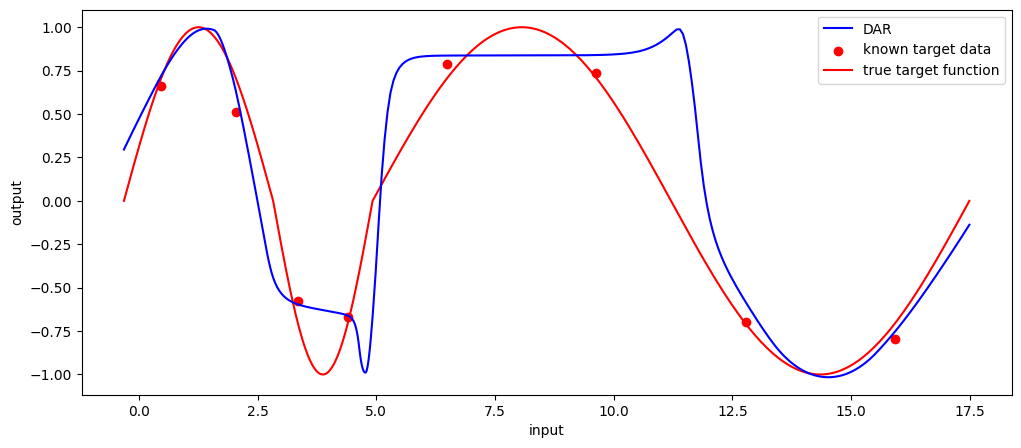

In [31]:
plt.figure(figsize=(12,5))
plt.plot(x_t, y_t_hat.detach().numpy(), c='blue', label='DAR', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()